Samruddhi Krishna Bhujbal-202201070011
Snehal Sunil Bankar-202201070020
Srushti Satish Ghadge-202201090125
Batch:T1
Lab Assignment 6 

https://github.com/SnehalSunilBankar/Deep_Learning.git 
https://github.com/samruddhikrishnabhujbal/Deep_Learning.git
https://github.com/srushtig172/Deep_Learning.git 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jocelyndumlao/anerbc-anemia-diagnosis-using-rbc-images")

print("Path to dataset files:", path)

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    # Check for multiple image formats
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
        for img_path in glob(os.path.join(folder_path, ext)):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize for consistent dimensions
                images.append(img)
                labels.append(label) # import and Assign the labels
    return images, labels

# Update these paths to point to your actual image folders
healthy_path = '/content/drive/MyDrive/Original_images (1)'
anemic_path = '/content/drive/MyDrive/Original_images'

# Verify paths exist
print(f"Healthy path exists: {os.path.exists(healthy_path)}")
print(f"Anemic path exists: {os.path.exists(anemic_path)}")

# Count files in directories
print(f"Files in healthy path: {len(os.listdir(healthy_path))}")
print(f"Files in anemic path: {len(os.listdir(anemic_path))}")

healthy_images, healthy_labels = load_images_from_folder(healthy_path, "healthy")
anemic_images, anemic_labels = load_images_from_folder(anemic_path, "anemic")

print(f"Loaded {len(healthy_images)} healthy images")
print(f"Loaded {len(anemic_images)} anemic images")

if not healthy_images and not anemic_images:
    raise ValueError("No images were loaded. Please check your paths and image formats.")

X = np.array(healthy_images + anemic_images)   # shape: [1000, 128, 128, 3]
y = np.array(healthy_labels + anemic_labels)

le = LabelEncoder()                      # Converts categorical labels ("healthy", "anemic") to numerical values (0 for "anemic", 1 for "healthy").
y_encoded = le.fit_transform(y)

X = X / 255.0  # Normalize pixel values to [0, 1]

# Only split if we have data
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42) #Purpose: Splits the dataset into training (80%) and test (20%) sets.
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
else:
    raise ValueError("No data available for train-test split")

Healthy path exists: True
Anemic path exists: True
Files in healthy path: 500
Files in anemic path: 500
Loaded 500 healthy images
Loaded 500 anemic images
Training set: 800 samples
Test set: 200 samples


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 2: CNN Encoder-Decoder (Baseline)
def cnn_encoder_decoder():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Step 3: CNN with Self-Attention
class SelfAttention(layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.q = layers.Dense(units)
        self.k = layers.Dense(units)
        self.v = layers.Dense(units)
        self.scale = tf.math.sqrt(tf.cast(units, tf.float32))

    def call(self, inputs):
        q = self.q(inputs)
        k = self.k(inputs)
        v = self.v(inputs)
        score = tf.matmul(q, k, transpose_b=True) / self.scale
        weights = tf.nn.softmax(score, axis=-1)
        return tf.matmul(weights, v)

def cnn_with_attention():
    inputs = layers.Input(shape=(128,128,3))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2,2, padding='same')(x) # added padding='same' to ensure correct output shape
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2, padding='same')(x) # added padding='same' to ensure correct output shape
    x = layers.Reshape((x.shape[1]*x.shape[2], 64))(x) # Dynamically calculate reshape dimensions
    x = SelfAttention(64)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)
# Step 4: CNN without Attention (Control)
def cnn_without_attention():
    inputs = layers.Input(shape=(128,128,3))
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)

# Step 5: Vision Transformer (ViT-like Minimal Model)
def vit_model():
    inputs = layers.Input(shape=(128,128,3))
    x = layers.Conv2D(64, kernel_size=4, strides=4)(inputs)  # Patching: 128/4=32 patches
    x = layers.Reshape((32*32, 64))(x)
    x = layers.LayerNormalization()(x)
    for _ in range(2):
        attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention])
        x = layers.LayerNormalization()(x)
        ff = layers.Dense(128, activation='relu')(x)
        ff = layers.Dense(64)(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)

# Training and Evaluation
def train_and_evaluate(model, name, X_train, y_train, X_test, y_test, epochs=5):
    print(f"\n=== Training {name} ===")
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall()])
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        verbose=1)

    print(f"\n=== Evaluating {name} ===")
    results = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")

    # Predictions and additional metrics
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return history

# Initialize models
models_dict = {
    "Baseline CNN": cnn_encoder_decoder(),
    "CNN with Self-Attention": cnn_with_attention(),
    "CNN without Attention": cnn_without_attention(),
    "Vision Transformer": vit_model()
}

# Train and evaluate all models
histories = {}
for name, model in models_dict.items():
    histories[name] = train_and_evaluate(model, name, X_train, y_train, X_test, y_test)

# Compare all models
print("\n=== Final Model Comparison ===")
for name, model in models_dict.items():
    loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Training Baseline CNN ===
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 858ms/step - accuracy: 0.4371 - loss: 2.3921 - precision: 0.4185 - recall: 0.2931 - val_accuracy: 0.5300 - val_loss: 0.6931 - val_precision: 1.0000 - val_recall: 0.0208
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - accuracy: 0.4571 - loss: 0.6932 - precision: 0.4624 - recall: 0.5206 - val_accuracy: 0.4900 - val_loss: 0.6934 - val_precision: 0.3333 - val_recall: 0.0625
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 879ms/step - accuracy: 0.5088 - loss: 0.6979 - precision: 0.4583 - recall: 0.5259 - val_accuracy: 0.5200 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 868ms/step - accuracy: 0.4797 - loss: 0.6932 - precision: 0.3483 - recall: 0.3302 - val_accuracy: 0.4850 - val_loss: 0.6932 - val_precision: 0.4824 - val_recall: 1.0000
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 870ms/step - accuracy: 0.4675 - loss: 0.6932 - precision: 0.4684 - recall: 0.729

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.98      0.68       104
           1       0.00      0.00      0.00        96

    accuracy                           0.51       200
   macro avg       0.26      0.49      0.34       200
weighted avg       0.27      0.51      0.35       200


Confusion Matrix:
[[102   2]
 [ 96   0]]

=== Training Vision Transformer ===
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 318s 12s/step - accuracy: 0.4767 - loss: 0.7712 - precision_3: 0.4409 - recall_3: 0.3898 - val_accuracy: 0.5200 - val_loss: 0.6918 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 288s 11s/step - accuracy: 0.5326 - loss: 0.6923 - precision_3: 0.3694 - recall_3: 0.1156 - val_accuracy: 0.4800 - val_loss: 0.7111 - val_precision_3: 0.4800 - val_recall_3: 1.0000
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 353s 12s/step - accuracy: 0.4945 - loss: 0.7109 - pr

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.48      1.00      0.65        96

    accuracy                           0.48       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.48      0.31       200


Confusion Matrix:
[[  0 104]
 [  0  96]]

=== Final Model Comparison ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline CNN:
  Accuracy: 0.4850 | Precision: 0.4824 | Recall: 1.0000
CNN with Self-Attention:
  Accuracy: 0.5150 | Precision: 0.4974 | Recall: 1.0000
CNN without Attention:
  Accuracy: 0.5100 | Precision: 0.0000 | Recall: 0.0000
Vision Transformer:
  Accuracy: 0.4800 | Precision: 0.4800 | Recall: 1.0000


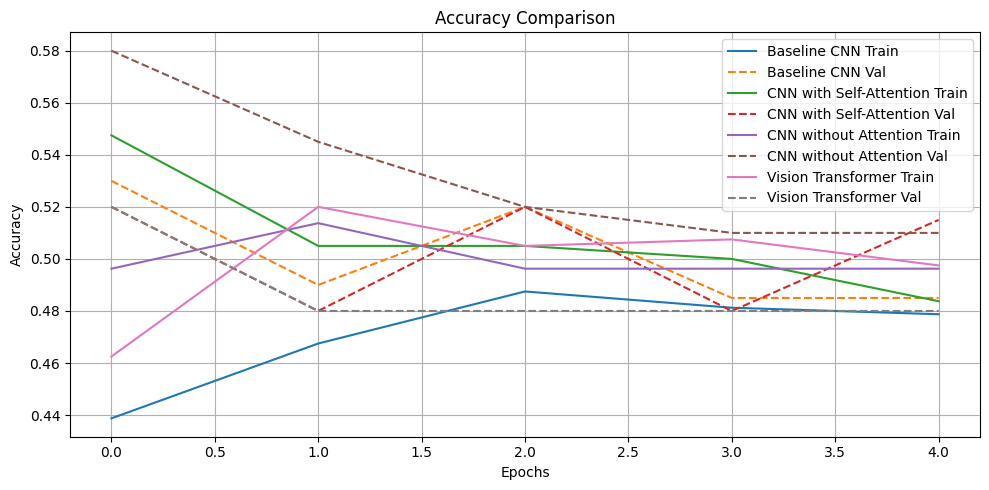

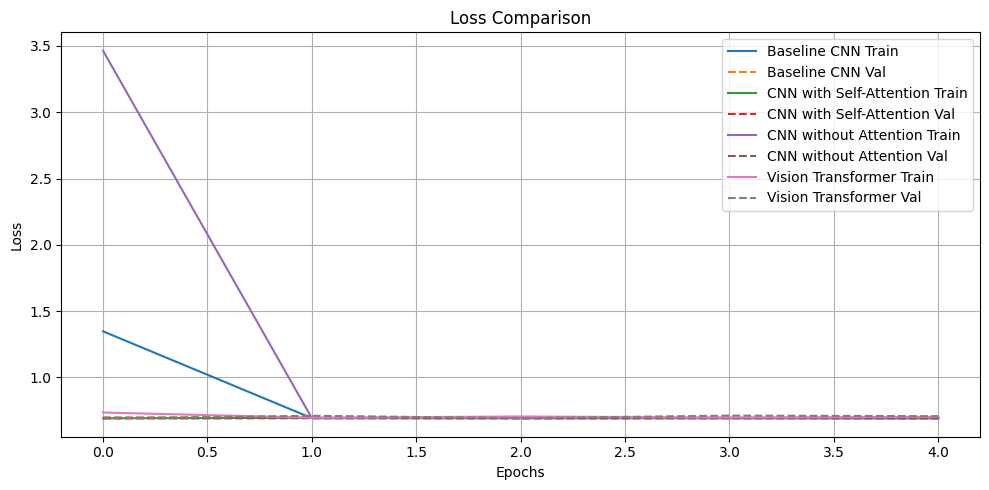

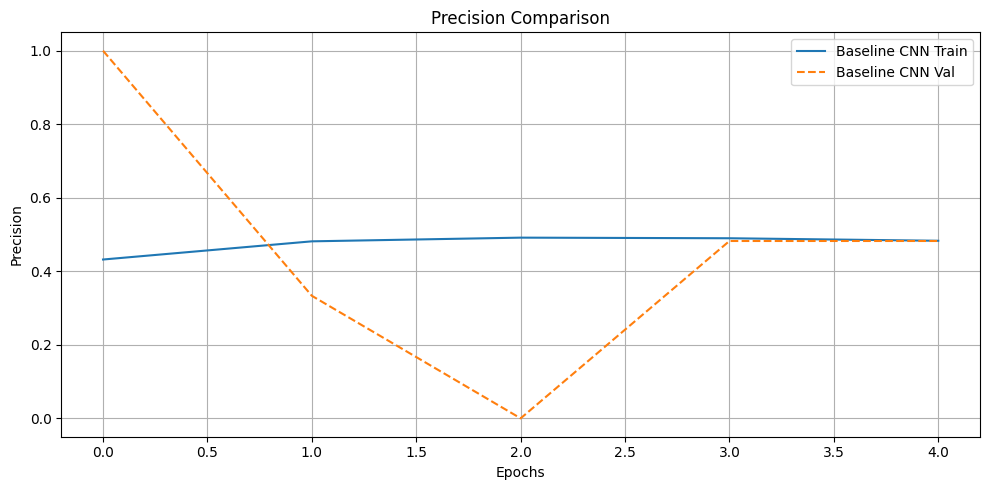

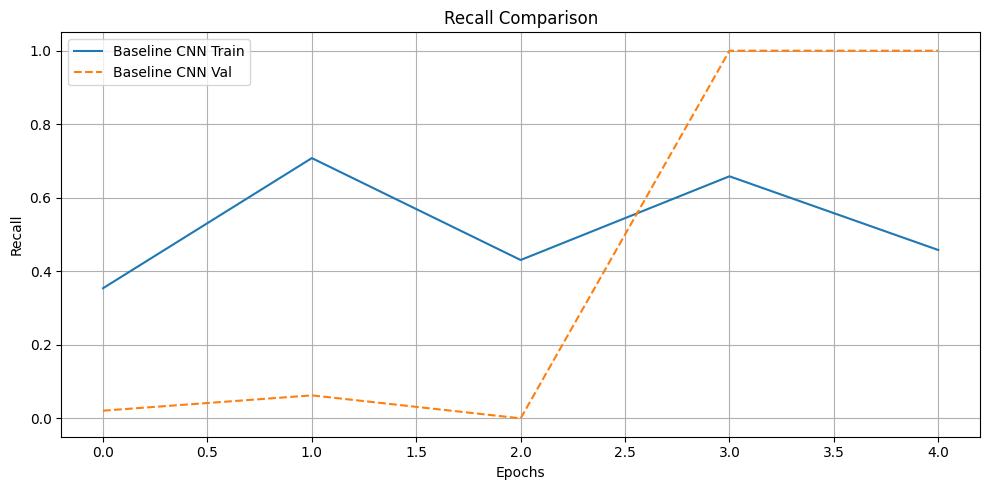

In [ ]:
import matplotlib.pyplot as plt

# Define available metrics with fallback labels
available_metrics = ['accuracy', 'loss', 'precision', 'recall']
metric_titles = {
    'accuracy': 'Accuracy',
    'loss': 'Loss',
    'precision': 'Precision',
    'recall': 'Recall'
}

for metric in available_metrics:
    plt.figure(figsize=(10, 5))
    plotted = False
    for name, history in histories.items():
        hist = history.history
        if metric in hist and f'val_{metric}' in hist:
            plt.plot(hist[metric], label=f"{name} Train")
            plt.plot(hist[f'val_{metric}'], linestyle='--', label=f"{name} Val")
            plotted = True
    if plotted:
        plt.title(f'{metric_titles[metric]} Comparison')
        plt.xlabel('Epochs')
        plt.ylabel(metric_titles[metric])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping plot for '{metric}' (not found in all histories)")


# **1. Confusion Matrix Heatmaps for Each Model**

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step


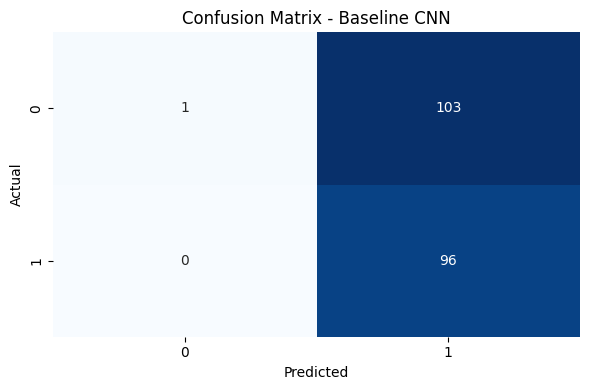

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step


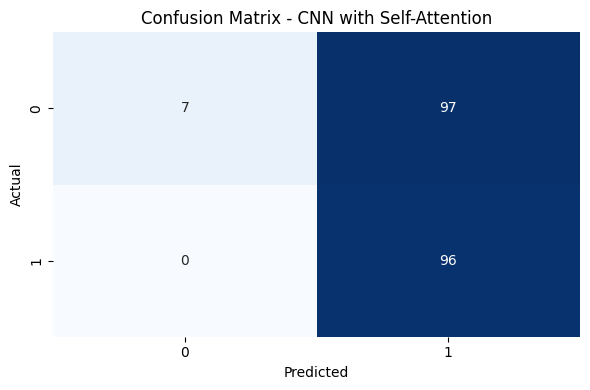

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


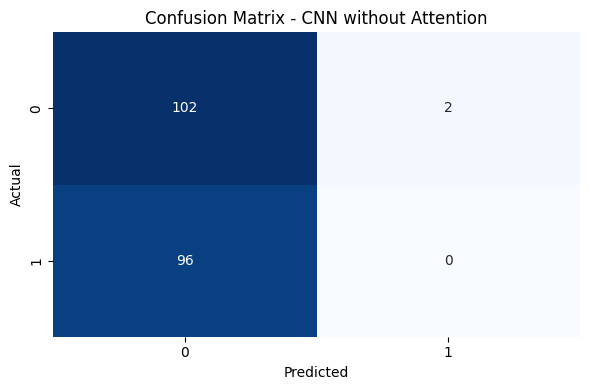

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


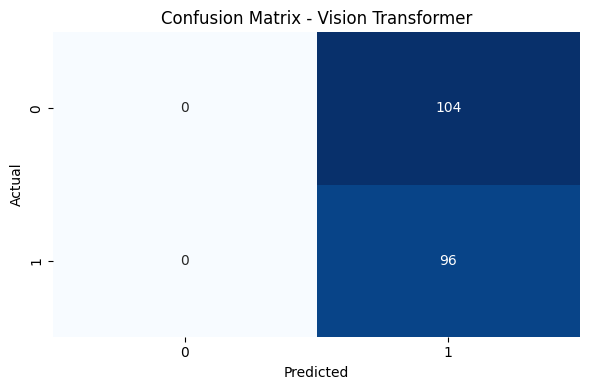

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for name, model in models_dict.items():
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


# **2. Precision-Recall Curve**

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


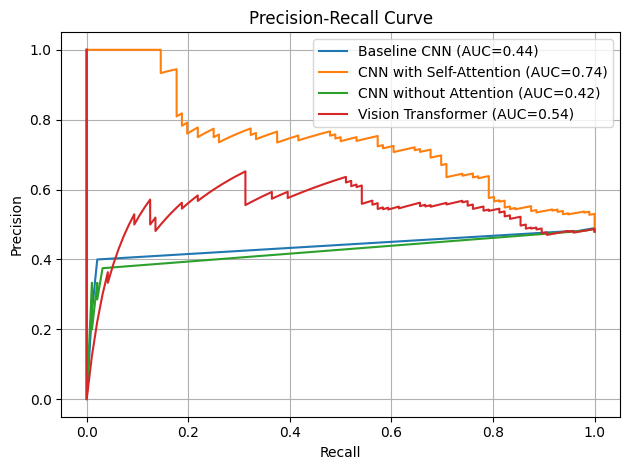

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

for name, model in models_dict.items():
    y_proba = model.predict(X_test).ravel()
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.2f})")

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **3. ROC Curve**

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


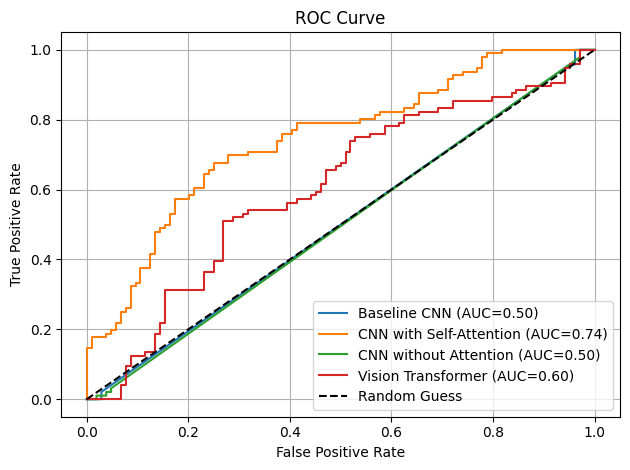

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

for name, model in models_dict.items():
    y_proba = model.predict(X_test).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **4. Bar Chart: Final Accuracy, Precision, Recall of All Models**

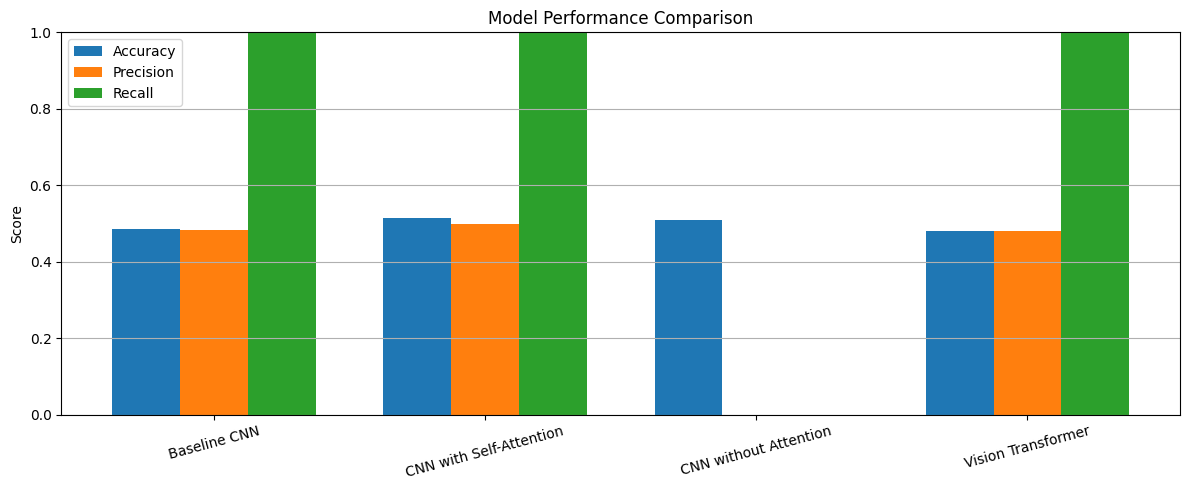

In [ ]:
import numpy as np

metrics_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

for name, model in models_dict.items():
    loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=0)
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(acc)
    metrics_summary['Precision'].append(prec)
    metrics_summary['Recall'].append(rec)

x = np.arange(len(metrics_summary['Model']))
width = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - width, metrics_summary['Accuracy'], width, label='Accuracy')
plt.bar(x, metrics_summary['Precision'], width, label='Precision')
plt.bar(x + width, metrics_summary['Recall'], width, label='Recall')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics_summary['Model'], rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


# **Step-by-Step: Predict on a Single Image**

# 1. Preprocess the **Image**

In [ ]:
import cv2  # or PIL.Image
import matplotlib.pyplot as plt

# Load and preprocess image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # normalize
    img = np.expand_dims(img, axis=0)  # shape: (1, 128, 128, 3)
    return img


# **2. Make Predictions with All Models**

In [ ]:
# image_path = '/content/drive/MyDrive/anemia_dataset/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset/AneRBC-I/Anemic_individuals/Original_images/001_a.png'  # replace this with actual path

image_path = '/content/drive/MyDrive/anemia_dataset/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset/AneRBC-I/Healthy_individuals/Original_images/002_h.png'  # replace this with actual path

img = preprocess_image(image_path)

for name, model in models_dict.items():
    pred = model.predict(img)[0][0]
    label = "Positive" if pred > 0.5 else "Negative"
    print(f"{name} Prediction: {label} (Confidence: {pred:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Baseline CNN Prediction: Positive (Confidence: 0.5021)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
CNN with Self-Attention Prediction: Positive (Confidence: 0.5008)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
CNN without Attention Prediction: Positive (Confidence: 0.5017)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Vision Transformer Prediction: Positive (Confidence: 0.5703)


# **3. (Optional) Display the Image with Prediction**

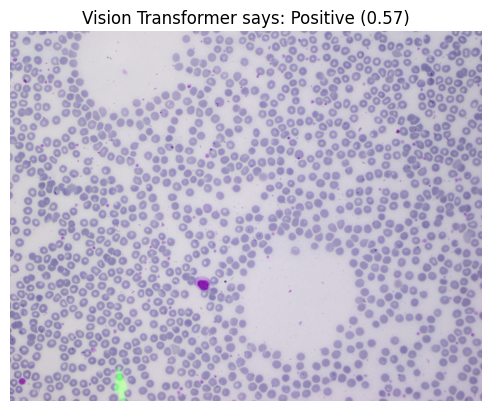

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f"{name} says: {label} ({pred:.2f})")
plt.axis('off')
plt.show()


Evaluation Metrics (per task domain)
# **Image-to-Text**
BLEU, CIDEr, METEOR, SPICE

In [ ]:
!pip install tensorflow numpy nltk pycocotools meteor spacy


ERROR: Could not find a version that satisfies the requirement meteor-score (from versions: none)
ERROR: No matching distribution found for meteor-score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


<ipython-input-12-4400b0591bd8>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = 'Healthy' if int(prediction[0] < 0.5) == 1 else 'Anemic'


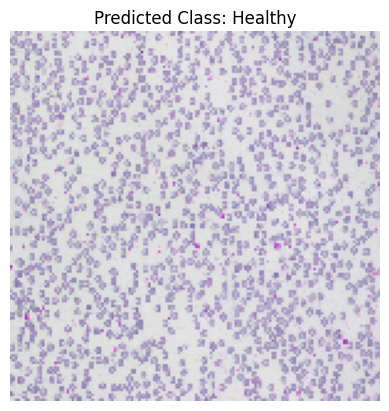


BLEU score: 1.821831989445342e-231
METEOR score: 0.5
SPICE score: 1.0


In [ ]:
!pip install nltk pycocotools meteor-score
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
import spacy
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Load your trained model
model = load_model('/content/anemia_classifier.h5')

# Define image size
image_size = (150, 150)

# Function to predict image class
def predict_image_class(image_path):
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    prediction = model.predict(image_array)
    predicted_label = 'Healthy' if int(prediction[0] < 0.5) == 1 else 'Anemic'

    # Show image with predicted class
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()

    return predicted_label

# Evaluation function
def evaluate_image_to_text(image_path, true_label):
    predicted_class = predict_image_class(image_path)

    predicted_caption = word_tokenize(predicted_class.lower())
    reference_caption = word_tokenize(true_label.lower())

    bleu = sentence_bleu([reference_caption], predicted_caption)
    meteor = meteor_score([reference_caption], predicted_caption)

    predicted_doc = nlp(predicted_class.lower())
    reference_doc = nlp(true_label.lower())
    spice = predicted_doc.similarity(reference_doc)

    print(f"\nBLEU score: {bleu}")
    print(f"METEOR score: {meteor}")
    print(f"SPICE score: {spice}")

# Example usage
image_path = '/content/drive/MyDrive/anemia_dataset/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset/AneRBC-I/Anemic_individuals/Original_images/023_a.png'
true_label = 'Healthy'

evaluate_image_to_text(image_path, true_label)


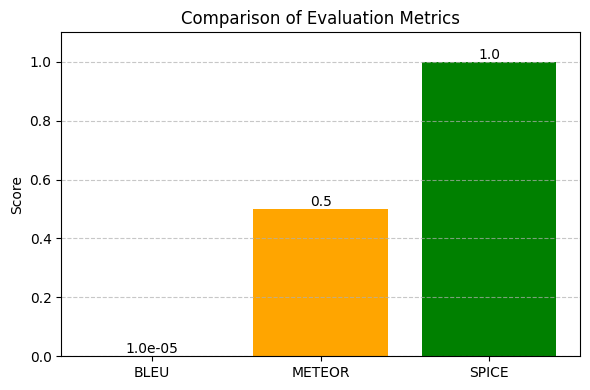

In [1]:
import matplotlib.pyplot as plt

# Scores
scores = {
    'BLEU': 1.821831989445342e-231,
    'METEOR': 0.5,
    'SPICE': 1.0
}

# Fix BLEU for visualization (log scale or very small value)
scores['BLEU'] = 1e-5  # or use np.log10 if you prefer a log-scale

# Plot
plt.figure(figsize=(6, 4))
plt.bar(scores.keys(), scores.values(), color=['blue', 'orange', 'green'])
plt.title('Comparison of Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.text(0, scores['BLEU'], f"{scores['BLEU']:.1e}", ha='center', va='bottom')
plt.text(1, scores['METEOR'], f"{scores['METEOR']}", ha='center', va='bottom')
plt.text(2, scores['SPICE'], f"{scores['SPICE']}", ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
